In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

In [2]:
import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '3' if USE_GPU else ''
EPS = 1e-15

In [3]:
lpmt_hits = pd.read_hdf('./juno/phase_3/lpmt_hits.h5', mode='r') 
spmt_hits = pd.read_hdf('./juno/phase_3/spmt_hits.h5', mode='r')
pmts_pos = pd.read_csv('./juno/pmts_pos.csv') 
true_info = pd.read_csv('./juno/phase_3/true_info.csv')

In [4]:
test_l_hits = pd.read_hdf('./juno/phase_3/test_l_hits.h5') 
test_s_hits = pd.read_hdf('./juno/phase_3/test_s_hits.h5')

In [5]:
train = pd.read_hdf('./juno/train_data_ph1.h5', mode='r') 
# validation = pd.read_hdf('../data/phase1/validation_data_ph1.h5', mode='r') 
test = pd.read_hdf('./juno/test_data_ph1.h5', mode='r') 
# true_info = pd.read_hdf('./juno/true_data_ph1.h5', mode='r') 

In [6]:
train.head()

,event,hitTime,pmtID,is_large,pmt_x,pmt_y,pmt_z,E,R,x,y,z
0,0,249.992615,14175,True,-5411.832,16838.455,-7471.1797,4.747791,14610.378,8290.779,11995.618,911.74286
1,0,92.820419,14175,True,-5411.832,16838.455,-7471.1797,4.747791,14610.378,8290.779,11995.618,911.74286
2,0,40.010311,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286
3,0,218.473663,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286
4,0,91.932716,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286


In [7]:
test.head()

,event,hitTime,pmtID,is_large,pmt_x,pmt_y,pmt_z
0,16000,130.768448,3289,True,2134.6404,15017.766,11770.728
1,16002,63.246658,3289,True,2134.6404,15017.766,11770.728
2,16007,85.495117,3289,True,2134.6404,15017.766,11770.728
3,16009,126.604965,3289,True,2134.6404,15017.766,11770.728
4,16015,67.194359,3289,True,2134.6404,15017.766,11770.728


In [8]:
true_info.head()

,E,R,evtID,x,y,z
0,7.397038,15267.927,26000,13759.8120,-2082.3127,6280.2180
1,8.934670,17321.850,26001,-11983.3910,12273.5100,2409.5234
2,5.901982,17258.846,26002,-16006.6580,2820.8100,-5804.9690
3,6.396549,6628.715,26003,937.7113,2855.7812,5908.0513
4,9.518383,16806.303,26004,-9749.3150,-3329.8782,13278.3510


In [9]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


### Merging data

In [10]:
train_df = pd.concat([lpmt_hits, spmt_hits], axis=0)
test_df = pd.concat([test_l_hits, test_s_hits], axis=0)
data = pd.concat([train_df, test_df], axis=0)
print(lpmt_hits.shape, spmt_hits.shape, train_df.shape)
print(test_l_hits.shape, test_s_hits.shape, test_df.shape)
print(data.shape)
split_idx = train_df.shape[0]

/mnt/vlopatkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


(149097158, 4) (3719775, 4) (152816933, 4)
(46549747, 3) (1162004, 3) (47711751, 3)
(200528684, 4)


In [11]:
split_idx = train_df.shape[0]

In [12]:
data.iloc[:split_idx].shape

(152816933, 4)

In [13]:
split_events = true_info.shape[0]
print(split_events)

16000


In [14]:
first_train_event_num = lpmt_hits.event.min()
first_test_event_num = test_l_hits.event.min()

In [15]:
first_test_event_num

42000

### Baseline

we're going to take mean of every real_numbered value

In [16]:
base_train = train[['event', 'hitTime', 'pmt_x', 'pmt_y', 'pmt_z']].groupby('event').mean()
base_test = test[['event', 'hitTime', 'pmt_x', 'pmt_y', 'pmt_z']].groupby('event').mean()

In [17]:
base_train.head()

,hitTime,pmt_x,pmt_y,pmt_z
event,,,,
0,95.142883,6742.747754,9929.261316,767.530051
1,98.507034,9148.488313,4254.463594,-5668.030986
2,96.424873,11465.888473,-3298.430170,215.455769
3,100.268799,-1500.403105,-11539.483607,2423.068899
4,104.633980,-7100.159824,709.128010,7903.695198


In [18]:
base_test.head()

,hitTime,pmt_x,pmt_y,pmt_z
event,,,,
16000,104.666626,-7187.699821,4022.543151,6771.929508
16001,93.139519,40.935368,-12232.407876,-28.051466
16002,124.935867,627.151867,5749.089462,4393.655642
16003,128.582108,5255.132815,2112.435941,-1009.168551
16004,106.997620,-8252.127742,6186.875231,883.975080


## Trying YuMalyshkin features

$N_{p.e.}$

meant $1_{st}$ hit time

center of hits E

center of hits Z

### Center of hits
$$
\frac{\sum_{i}^{Num\_of\_pmts}Position_{i} * hits\_per\_pmt}{Sphere\_radius * Num\_of\_pmts}
$$

In [19]:
sphere_radius = 19200

working with original data (not train/test separated)

In [20]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


In [21]:
#counting hits per pmt per event
CoH_hits = pd.DataFrame(data=data.groupby(['event','pmtID']).size(), columns=['hits']).reset_index()

#merging with pmt coordinates
CoH = CoH_hits.merge(pmts_pos.rename(columns={'pmt_id':'pmtID'}), on='pmtID', how='left')
CoH.head()

#multiplying values
CoH['X'] = CoH.hits * CoH.pmt_x
CoH['Y'] = CoH.hits * CoH.pmt_y
CoH['Z'] = CoH.hits * CoH.pmt_z

CoH_calculation = CoH.groupby('event').agg({'X' : 'sum','Y' : 'sum','Z' : 'sum', 'pmtID' : 'count'})
CoH_calculation.X /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.Y /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.Z /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.rename(columns={'pmtID':'unique_pmts'}, inplace=True)
CoH_calculation.head()

# X, Y, Z are Centers of hits for each of the exes for each event

features = CoH_calculation.copy()

features['1st_hit_time'] = data.groupby(['event'])['hitTime'].min()
features['mean_hit_time'] = data.groupby('event')['hitTime'].mean() / features['1st_hit_time']
features['pmt_per_event'] = data.groupby(['event'])['pmtID'].count()

In [22]:
features.head()

,X,Y,Z,unique_pmts,1st_hit_time,mean_hit_time,pmt_per_event
event,,,,,,,
26000,1.094521,-0.165550,0.499779,6680,-98.976997,-1.123225,13516
26001,-0.914811,0.933743,0.196754,6029,-99.931862,-1.129626,13512
26002,-1.059129,0.199717,-0.356538,4741,-98.432510,-1.236033,9436
26003,0.036566,0.161535,0.325428,7529,-98.627686,-1.489712,10305
26004,-0.727714,-0.255147,0.982586,6653,-95.256348,-1.215186,14555


In [23]:
features.shape

(21000, 7)

In [24]:
final_features = ['X', 'Y', 'Z', 'unique_pmts', 'mean_hit_time']

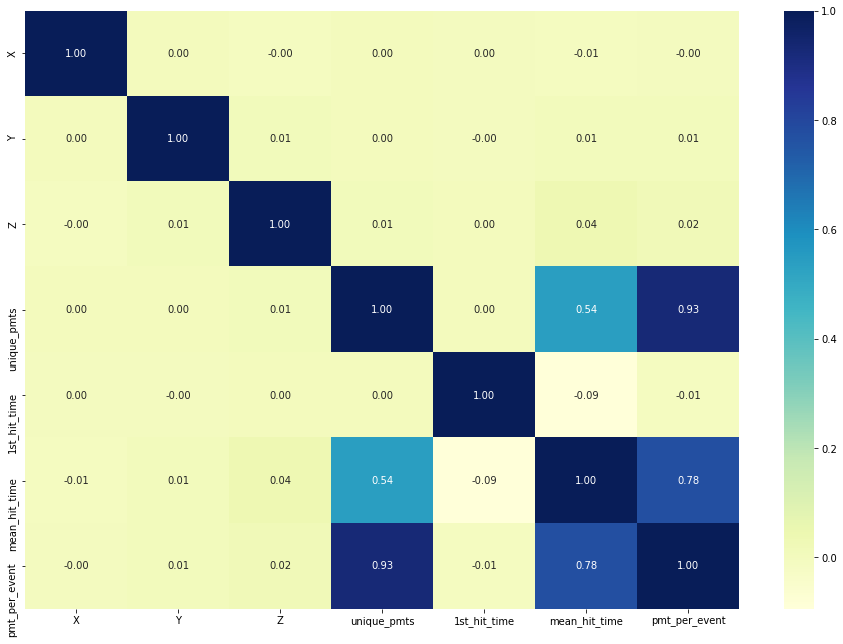

In [25]:
corr = features.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

In [26]:
features = features[final_features]

In [27]:
true_info.head()

,E,R,evtID,x,y,z
0,7.397038,15267.927,26000,13759.8120,-2082.3127,6280.2180
1,8.934670,17321.850,26001,-11983.3910,12273.5100,2409.5234
2,5.901982,17258.846,26002,-16006.6580,2820.8100,-5804.9690
3,6.396549,6628.715,26003,937.7113,2855.7812,5908.0513
4,9.518383,16806.303,26004,-9749.3150,-3329.8782,13278.3510


# CatBoost

In [28]:
X_train = features.iloc[:split_events]
X_test = features.iloc[split_events:]

In [29]:
X_test.head()

,X,Y,Z,unique_pmts,mean_hit_time
event,,,,,
42000,-0.206443,-0.833504,0.177160,3527,-1.426612
42001,-0.918808,0.709120,-0.433661,5988,-1.175502
42002,-0.107736,-0.423874,0.319924,4878,-1.521969
42003,-0.177832,-0.313203,-0.834091,4715,-1.341060
42004,0.218156,-0.029867,0.521956,2022,-1.862988


In [30]:
true_info.shape

(16000, 6)

In [31]:
from catboost import Pool, CatBoostRegressor

### baseline

In [32]:
baseline_train_pool_E = Pool(base_train.values, 
                  true_info["E"].values)
baseline_train_pool_R = Pool(base_train.values, 
                  true_info["R"].values)

In [33]:
baseline_model_E = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(baseline_train_pool_E, verbose=False)
baseline_model_R = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(baseline_train_pool_R, verbose=False)

In [35]:
print('E',baseline_model_E.score(baseline_train_pool_E))
print('R',baseline_model_E.score(baseline_train_pool_R))

E 2.8585610577072047
R 13708.851672438332
CPU times: user 1min 14s, sys: 3.04 s, total: 1min 17s
Wall time: 3.52 s


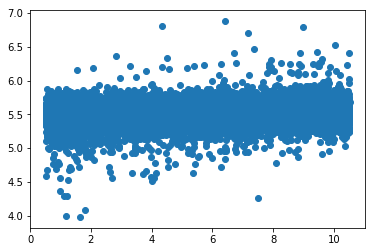

In [36]:
plt.scatter(true_info['E'].values, baseline_model_E.predict(baseline_train_pool_E))

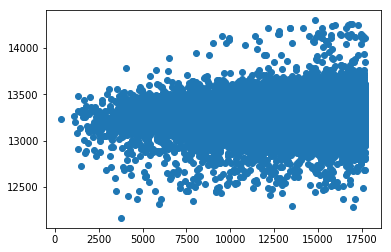

In [37]:
plt.scatter(true_info['R'].values, baseline_model_R.predict(baseline_train_pool_R))

### Model with new features

In [38]:
train_pool_E = Pool(X_train.values, 
                  true_info["E"].values)
train_pool_R = Pool(X_train.values, 
                  true_info["R"].values)

In [39]:
%%time
model_E = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(train_pool_E, verbose=False)
model_R = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(train_pool_R, verbose=False)

CPU times: user 1min 11s, sys: 3.01 s, total: 1min 14s
Wall time: 3.3 s


In [ ]:
%%time
baseline_model_E.fit(baseline_train_pool_E, verbose=False)
print('E',baseline_model_E.score(baseline_train_pool_E))


baseline_model_R.fit(baseline_train_pool_R, verbose=False)
print('R',baseline_model_E.score(baseline_train_pool_R))

In [45]:
print('E', model_E.score(train_pool_E))
print('R', model_R.score(train_pool_R))

E 0.4949287868152263
R 722.0733231787132


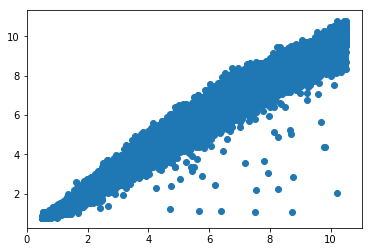

In [41]:
plt.scatter(true_info['E'].values, model_E.predict(train_pool_E) )

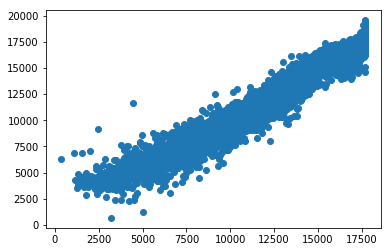

In [43]:
plt.scatter(true_info['R'].values, model_R.predict(train_pool_R) )

In [44]:
total_score = model_R.score(train_pool_R)**2 /100000 + model_E.score(train_pool_E)**2 *100
print(total_score)

29.70934924230267


### R2

In [46]:
from sklearn.metrics import r2_score

In [55]:
# baseline
print('E:',r2_score(true_info["E"].values, baseline_model_E.predict(baseline_train_pool_E)))
print('R:', r2_score(true_info["R"].values, baseline_model_R.predict(baseline_train_pool_R)))

E: 0.013358286713127332
R: 0.012112472081515446


In [50]:
# model
print('E:',r2_score(true_info["E"].values, model_E.predict(train_pool_E)))
print('R:', r2_score(true_info["R"].values, model_R.predict(train_pool_R)))

E: 0.9704232836768077
R: 0.9554926451527069


In [321]:
test_df.head()

,event,hitTime,pmtID
0,42000,147.795425,8148
1,42000,69.408455,6882
2,42000,32.437996,7980
3,42000,156.244049,3259
4,42000,30.082300,6061


In [322]:
test_pool_E = Pool(X_test.values)

In [323]:
test_pool_R = Pool(X_test.values)

In [324]:
test_pred_E = model_E.predict(test_pool_E)
test_pred_R = model_R.predict(test_pool_R)

In [232]:
X_test.head()

,X,Y,Z,unique_pmts,mean_hit_time
evtID,,,,,
16000,-0.538896,0.301589,0.507724,4125,3.349956
16001,0.004258,-1.272360,-0.002918,5858,4.469581
16002,0.038645,0.354262,0.270740,3435,2.327208
16003,0.366788,0.147440,-0.070436,6813,2.070033
16004,-0.861649,0.646005,0.092301,8375,3.070578


In [246]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


In [263]:
solution = pd.DataFrame({'R':test_pred_R,'E':test_pred_E}, index=test_l_hits.event.unique())
solution.index.names = ['evtID']
solution.head()

,R,E
evtID,,
42000,13359.792436,5.455857
42001,12842.437275,5.322416
42002,13271.597981,5.665275
42003,13416.157125,5.571443
42004,13116.816491,5.450637


In [264]:
solution.to_csv('solution.csv')

## Torch NN

4 layers with 100 neurons each

4 inputs: 
- $N_{p.e.}$(LPMT)
- mean $1^{st}$ hit time
- center-of-hits R-component
- center-of-hits Z-component

2 outputs:
- E
- R

In [54]:
lpmt_train = train[train['is_large'] == True].drop('is_large', axis=1)
lpmt_train.head()

In [57]:
true_info.head()

,E,R,evtID
0,4.747791,14610.378,0
1,3.919721,14630.141,1
2,6.823932,14573.132,2
3,3.765940,16820.080,3
4,3.217473,13026.938,4


In [85]:
! cat /etc/os-release

NAME="Ubuntu"
VERSION="16.04.2 LTS (Xenial Xerus)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 16.04.2 LTS"
VERSION_ID="16.04"
HOME_URL="http://www.ubuntu.com/"
SUPPORT_URL="http://help.ubuntu.com/"
BUG_REPORT_URL="http://bugs.launchpad.net/ubuntu/"
VERSION_CODENAME=xenial
UBUNTU_CODENAME=xenial


In [86]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
torch.__version__

'1.0.1.post2'

In [10]:
# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h, n_out = 4, 100, 2

In [11]:
# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out))
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Linear(in_features=100, out_features=2, bias=True)
)


In [12]:
# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [19]:
X_train.values.shape

(140280336, 12)

In [20]:
y_train.values.shape

(140280336, 2)

In [ ]:
140280336 / 1024 * 10 

In [21]:
X_train['is_large'] = X_train['is_large'].apply(lambda x: 1 if True else 0)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140280336 entries, 0 to 140280335
Data columns (total 12 columns):
event       int64
hitTime     float32
pmtID       int32
is_large    int64
pmt_x       float64
pmt_y       float64
pmt_z       float64
E           float64
R           float64
x           float64
y           float64
z           float64
dtypes: float32(1), float64(8), int32(1), int64(2)
memory usage: 12.5 GB


In [22]:
train_loss = []
# Gradient Descent
for epoch in range(10):
    idx = np.random.choice(X_train.shape[0], 1024)
    X_batch = torch.tensor(X_train.iloc[idx].values)
    y_batch = torch.tensor(y_train.iloc[idx].values)
    # train on batch
    y_pred_batch = model(X_batch)
    loss = compute_loss(y_pred_batch, y_batch)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(loss.cpu().data.numpy())

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [47]:
X_train.shape[0]

140280336

In [59]:
idx = np.random.choice(X_train.shape[0], 10)
X_train.loc[idx].shape

(10, 12)